In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

# Load from env
load_dotenv()

model = init_chat_model("gpt-4o-mini")

In [18]:
from pathlib import Path

base_path = Path.cwd().parent.parent.parent
db_path = base_path / "resource" / "art.db"


print("Base Path:", base_path)
print("Database Path:", db_path)

Base Path: /home/afiq/fyp/fafa-repo/backend/app
Database Path: /home/afiq/fyp/fafa-repo/backend/app/resource/art.db


In [ ]:
from langchain_community.utilities import SQLDatabase
sql_url = f"sqlite:///{db_path.resolve()}"
db = SQLDatabase.from_uri(sql_url)

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM paintings LIMIT 5;")}')

Dialect: sqlite
Available tables: ['paintings']
Sample output: [('Predella of the Barbadori altarpiece', '1438-01-01 00:00:00', 'Renaissance', 'religious art', 'http://commons.wikimedia.org/wiki/Special:FilePath/Predella%20Pala%20Barbadori-%20Uffizi.JPG', 'images/img_0.jpg'), ('Judith', '1525-01-01 00:00:00', 'Renaissance', 'religious art', 'http://commons.wikimedia.org/wiki/Special:FilePath/Palma%20il%20Vecchio%20-%20Judith%20-%20WGA16936.jpg', 'images/img_1.jpg'), ('Judith', '1528-01-01 00:00:00', 'Renaissance', 'religious art', 'http://commons.wikimedia.org/wiki/Special:FilePath/Palma%20il%20Vecchio%20-%20Judith%20-%20WGA16936.jpg', 'images/img_2.jpg'), ('Die durch Engel bekrönte Muttergottes mit Kind im Kreise der 14 Schutzheiligen des Hauses Zimmern', '1536-01-01 00:00:00', 'Renaissance', 'religious art', 'http://commons.wikimedia.org/wiki/Special:FilePath/Meister%20von%20Me%C3%9Fkirch-Wildensteiner%20Altar-Mitteltafel-0014.jpg', 'images/img_3.jpg'), ('Der kniende Stifter Graf Got

In [21]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [27]:
from typing import Literal

# from langchain.messages import AIMessage
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = model.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = model.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = model.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [28]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

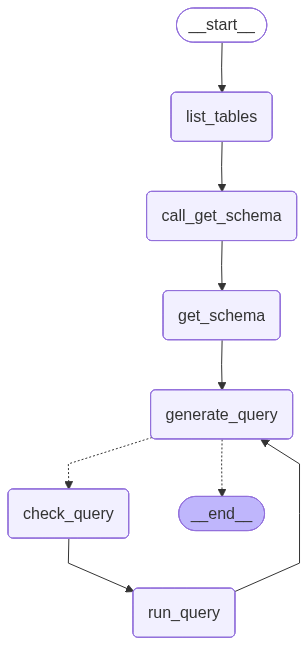

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [31]:
question = "Which genre has the oldest painting?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre has the oldest painting?
================================== Ai Message ==================================

Available tables: paintings
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_5jRuPJQr52gfZeMYEhvQ2kmR)
 Call ID: call_5jRuPJQr52gfZeMYEhvQ2kmR
  Args:
    table_names: paintings
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE paintings (
	title TEXT, 
	inception DATETIME, 
	movement TEXT, 
	genre TEXT, 
	image_url TEXT, 
	img_path TEXT
)

/*
3 rows from paintings table:
title	inception	movement	genre	image_url	img_path
Predella of the Barbadori altarpiece	1438-01-01 00:00:00	Renaissance	religious art	http://commons.wikimedia.org/wiki/Special:FilePath/Predella%20Pala%20Barbadori-%20Uffizi.JPG	images/img_0.jpg
Judith	1525-01-01 00:00:00	Renaissance	religious 